In [34]:
import numpy as np
import matplotlib.pylab as plt

In [98]:
class SpikeTimesteps:
    def __init__(self, layer_sizes):
        self.spike_timesteps = []
        for sz in layer_sizes:
            self.spike_timesteps.append(np.zeros((sz)))
    
    def __setitem__(self, idx, spike):
        self.spike_timesteps[idx] = np.maximum(self.spike_timesteps[idx], spike)
    
    def __getitem__(self, idx):
        return self.spike_timesteps[idx]
    
    def __len__(self):
        return len(self.spike_timesteps)
    
    def __iter__(self):
        return self.spike_timesteps

In [104]:
class Eta:
    def __init__(self, nu=1, tau=1):
        self.nu = nu
        self.tau = tau
        
    def __call__(self, s):
        return -self.nu * np.exp(-s / self.tau) * np.heaviside(s, 0)

    
class Eps:
    def __init__(self, tau=1):
        self.tau = tau
    
    def __call__(self, s, d):
        x = (s - d) / self.tau
        return x * np.exp(-x) * np.heaviside(s - d, 0)

    
class SpikingLayer:
    def __init__(self, in_size, out_size, d_lo=1, d_hi=5, nu=1, tau_eta=1, tau_eps=1):
        self.eta = Eta(nu, tau_eta)
        self.eps = Eps(tau_eps)
        self.w = np.random.uniform(size=(in_size, out_size))
        self.d = np.random.uniform(d_lo, d_hi, size=(in_size, out_size))
    
    def __call__(self, t, t_j, t_i):
        eta_term = self.eta(t - t_j)
        s = (t - t_i - self.d.T).T
        sum_term = np.sum(self.w * self.eps(s, self.d), axis=0)
        return eta_term + sum_term


class SRM:
    def __init__(self, input_size, hidden_sizes, output_size, threshold, nu, tau_eta, tau_eps):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        self.threshold = threshold
        self.sizes = [input_size] + hidden_sizes + [output_size]
        size_pairs = list(zip(self.sizes[:-1], self.sizes[1:]))
        self.layers = []
        print(size_pairs)
        for h1, h2 in size_pairs:
            self.layers.append(
                SpikingLayer(
                    in_size=h1,
                    out_size=h2,
                    d_lo=1,
                    d_hi=5,
                    nu=nu,
                    tau_eta=tau_eta,
                    tau_eps=tau_eps
                )
            )

    def __call__(self, x, num_timesteps):
        spike_list = [np.zeros((size, num_timesteps)) for size in self.sizes[1:]]
        u_list = [np.zeros((size, num_timesteps)) for size in self.sizes[1:]]
        last_ts = SpikeTimesteps(self.sizes)
        for ts in range(num_timesteps):
            for num, layer in enumerate(self.layers):
                u_list[num][:, ts] = layer(ts, last_ts[num + 1], last_ts[num])
                spike_list[num][:, ts] = (u_list[num][:, ts] > self.threshold).astype(int)
            
            spike_list_with_input = [x] + spike_list
            for num, is_spike in enumerate(spike_list_with_input):
                last_ts[num] = ts * is_spike[:, ts]
        
        return u_list, spike_list

In [105]:
def generate_pattern(input_size, total_time, lam=1, repeat=1):
    spike_list = []
    for _ in range(input_size):
        ts = int(-np.log(1 - np.random.sample()) / lam) + 1
        spike_row = [0] * total_time
        while ts < total_time:
            spike_row[ts] = 1
            delta = int(-np.log(1 - np.random.sample()) / lam) + 1
            ts += delta
        spike_list.append(spike_row)
    pattern = np.array(spike_list)
    pattern = np.repeat(pattern, repeat, axis=1)
    return pattern

In [342]:
def average_activity(layer_spikes):
    result = np.mean(layer_spikes, axis=0)
    
    return result

def most_active(layer_spikes):
    most_active_idx = np.argmax(np.sum(layer_spikes, axis=1))
    return layer_spikes[most_active_idx]

In [359]:
total_time = 1000
input_size = 5
hidden_sizes = [10, 20]
output_size = 2
threshold = 0.4
pattern1 = generate_pattern(input_size, total_time)
pattern2 = generate_pattern(input_size, total_time)
pattern3 = generate_pattern(input_size, total_time)

In [360]:
model = SRM(
    input_size=input_size, 
    hidden_sizes=hidden_sizes, 
    output_size=output_size,
    threshold=threshold, 
    nu=1, 
    tau_eta=1, 
    tau_eps=1
)

[(5, 10), (10, 20), (20, 2)]


In [367]:
def plot_pattern(pattern, total_time):
    results = []
    u_list, spike_list = model(pattern, total_time)

    for spikes in spike_list:
        avg = average_activity(spikes)
        act = most_active(spikes)
        results.append((avg, act))
    
    for avg, act in results:
        fig = plt.figure(figsize=(40,5))
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(range(total_time), avg)
        ax1.set_xlabel('time', fontsize=16)
        ax1.set_ylabel('average spike number', fontsize=16)
        
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(range(total_time), act)
        ax2.set_xlabel('time', fontsize=16)
        ax2.set_ylabel('spike', fontsize=16)

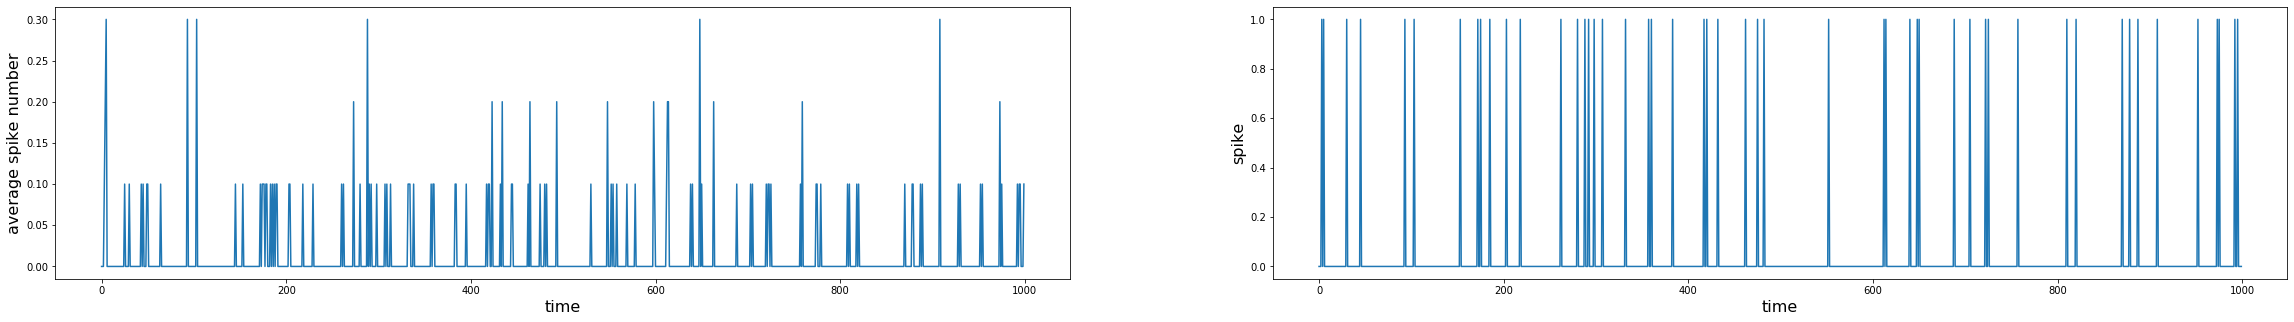

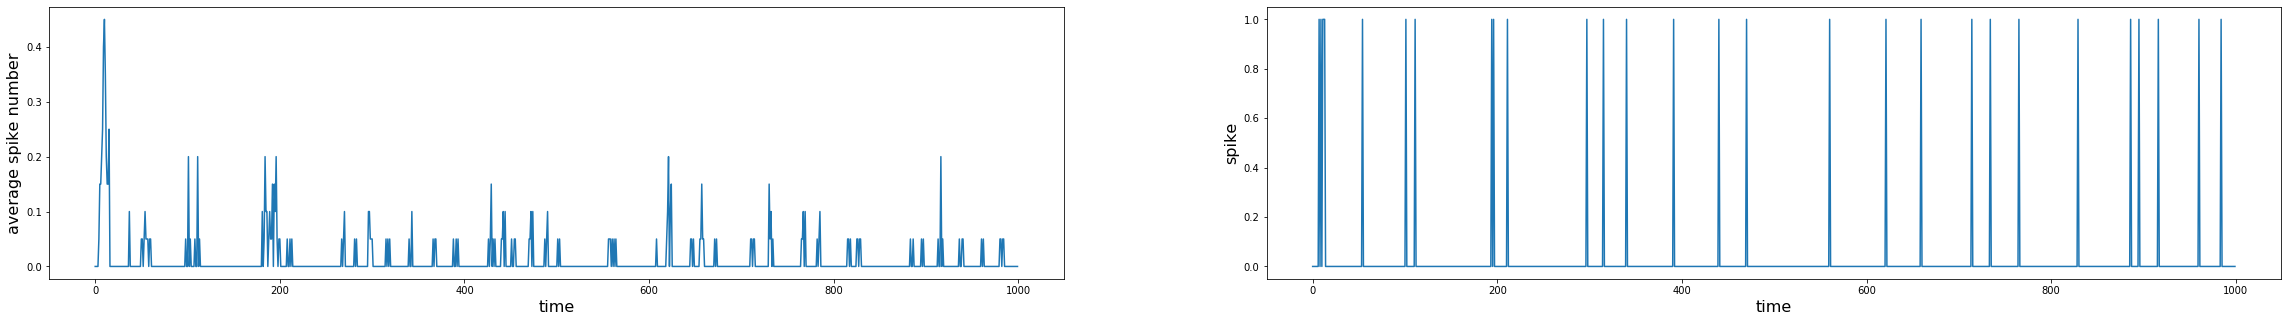

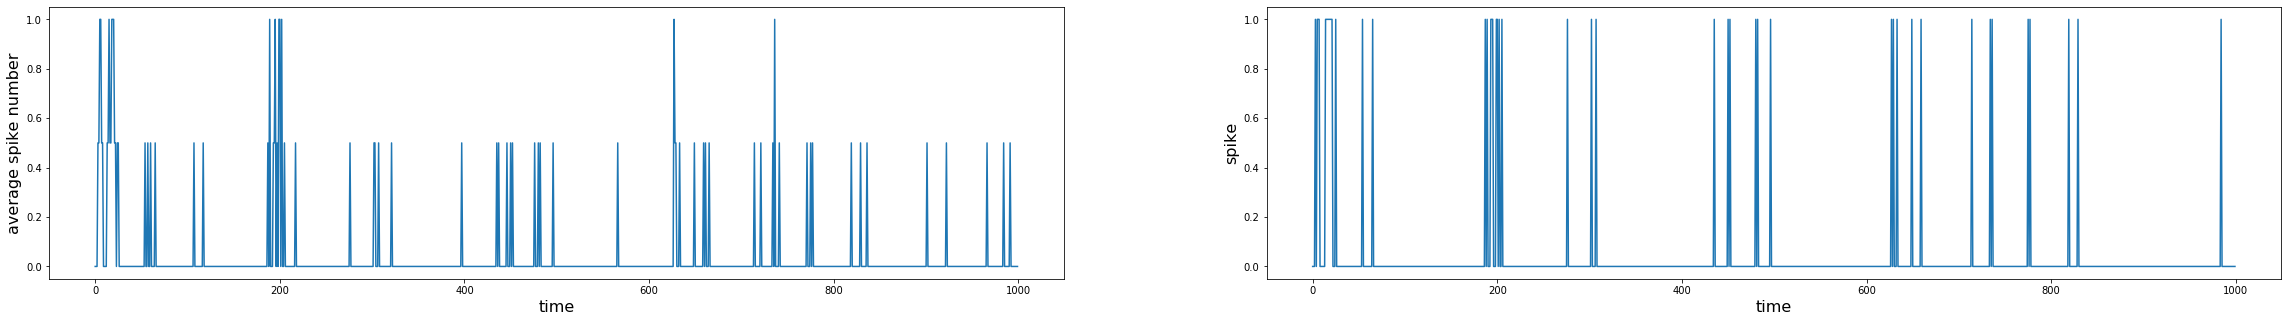

In [368]:
plot_pattern(pattern1, total_time)